# Packages

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
import os

import tensorflow as tf

# 启用 eager execution（确保它在 TensorFlow 2.x 中默认是启用的）
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, models

# Read Images and Masks

In [8]:

def create_data(data_dir):
    image_paths = []
    mask_paths = []
    
    # 设置图片和掩码文件夹的路径
    image_dir = os.path.join(data_dir, 'JPEGImages')
    mask_dir = os.path.join(data_dir, 'SegmentationClass')

    # 获取所有图像文件名，假设图像文件名与掩码文件名一致
    image_files = sorted(os.listdir(image_dir))

    for image_name in image_files:
        # 获取图像路径
        image_path = os.path.join(image_dir, image_name)

        # 构造对应的掩码路径
        mask_name = os.path.splitext(image_name)[0] + ".png"  # 假设掩码文件是.png格式
        mask_path = os.path.join(mask_dir, mask_name)

        # 检查掩码文件是否存在
        if os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)
        else:
            print(f"Warning: Mask file for {image_name} not found, skipping this image.")
    
    return image_paths, mask_paths

## Read images

In [9]:
# function to read an image
def load_image(image, SIZE):
    return np.round(tf.image.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    
    return images

## Load images and masks

In [10]:
SIZE = 256

# get data
data_dir = r'D:\training_set'
image_paths, mask_paths = create_data(data_dir)

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

In [11]:
len(imgs)

498

## Create colored mask function

In [12]:
def get_colored_mask(mask):
    colormap = plt.get_cmap('viridis')  
    colored_mask = colormap(mask.squeeze())
    return colored_mask

## Display some samples

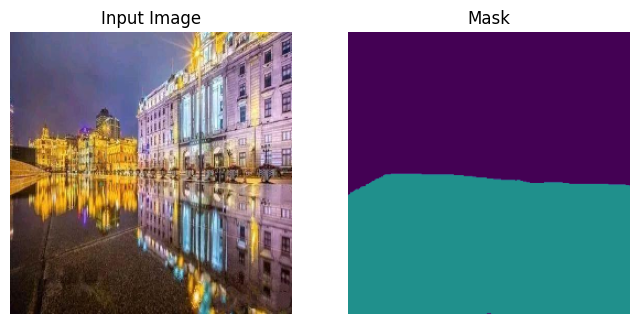

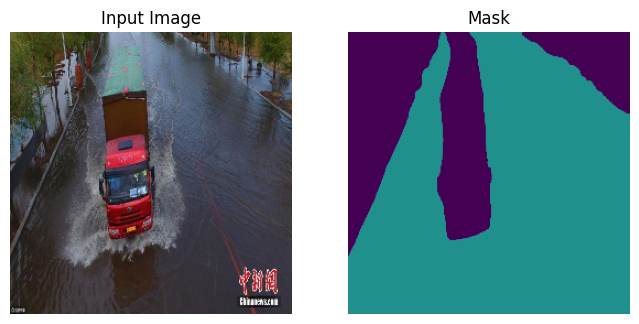

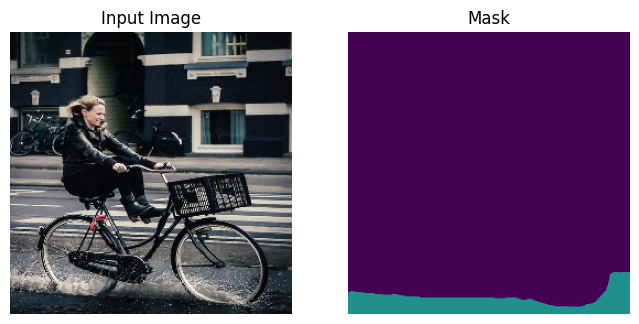

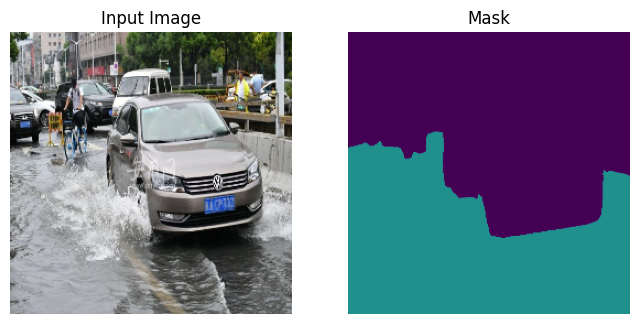

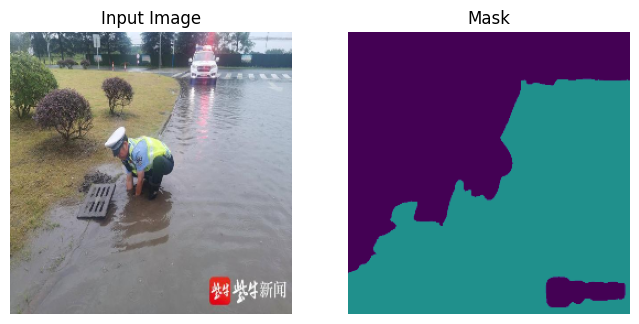

In [13]:
# 随机选择5个样本的索引
sample_indices = np.random.choice(len(imgs), 5, replace=False)

# 随机展示5张图像和对应的掩码
for i in sample_indices:
    plt.figure(figsize=(8, 6))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(imgs[i])  # 展示原图
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    colored_mask = get_colored_mask(msks[i])  # 展示彩色掩码
    plt.imshow(colored_mask)
    plt.axis('off')
    
    plt.show()

## Split data

In [14]:
# 随机打乱索引
indices = np.random.permutation(len(imgs))

# 计算80%数据作为训练集，20%数据作为测试集
size = int(len(imgs) * 0.8)

# 随机划分训练集和测试集
x_train = imgs[indices[:size]]
y_train = msks[indices[:size]]
x_test = imgs[indices[size:]]
y_test = msks[indices[size:]]

# U-Net architecture

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model

def u2net_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Contracting Path (Encoder with nested blocks)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Nested block for U^2-Net: Additional convolutional layers
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4], axis=3)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3], axis=3)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2], axis=3)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Compling

In [19]:
#加权损失函数
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy

# 自定义加权二元交叉熵损失函数
def weighted_binary_crossentropy(y_true, y_pred, water_weight=5.0, non_water_weight=1.0):
    # 计算二元交叉熵损失
    bce = BinaryCrossentropy()(y_true, y_pred)
    
    # 计算权重：如果真实标签为 0 (非水)，权重为 non_water_weight；如果真实标签为 1 (水)，权重为 water_weight
    weights = y_true * water_weight + (1 - y_true) * non_water_weight
    
    # 加权损失 = 权重 * 原始损失
    weighted_loss = weights * bce
    return K.mean(weighted_loss)

# 编译模型时使用自定义的加权损失函数
model = u2net_model(input_size=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [21]:
history = model.fit(
    x_train,
    y_train,
    batch_size=8, 
    epochs=10
)

Epoch 1/10


d:\python\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.5445 - loss: 1.0335
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.5804 - loss: 0.8189
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.5832 - loss: 0.8019
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.5826 - loss: 0.7528
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 308s 6s/step - accuracy: 0.5796 - loss: 0.7387
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - accuracy: 0.5617 - loss: 0.7700
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - accuracy: 0.5866 - loss: 0.7372
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - accuracy: 0.5855 - loss: 0.7090
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - accuracy: 0.5858 - loss: 0.7150
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - accuracy: 0.5974 - loss: 0.6868


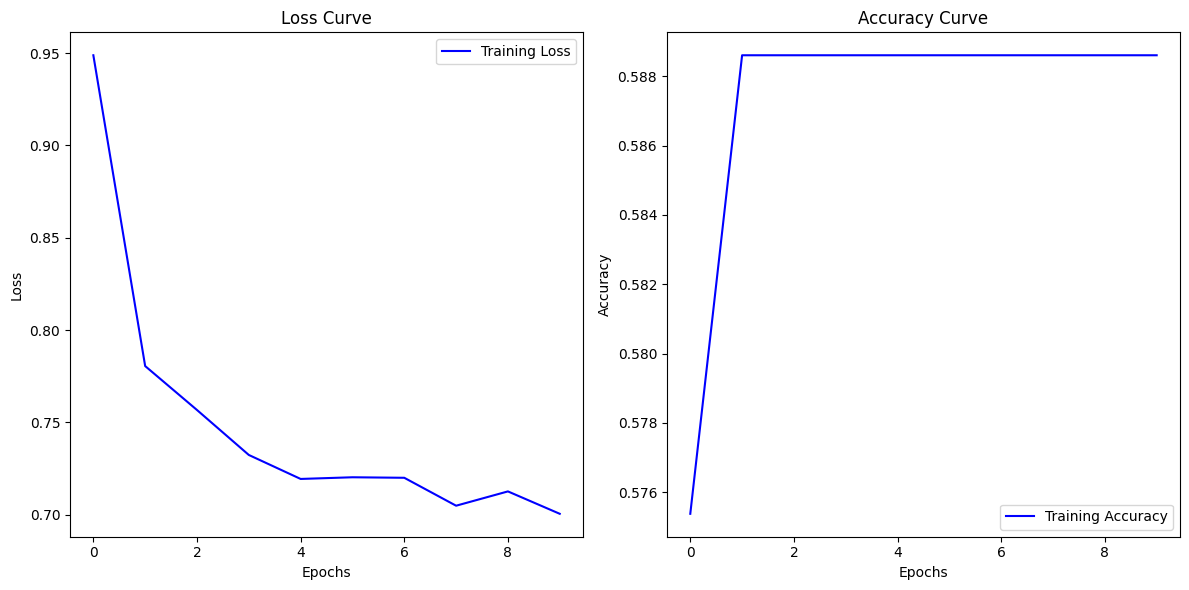

In [22]:

# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.5983 - loss: 0.6881
Test Loss: 0.7241875529289246
Test Accuracy: 0.5842587351799011


In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 将标签二值化（如果是多类别分类）
y_test_bin = label_binarize(np.argmax(y_test, axis=-1), classes=[0, 1, 2])  # 如果有多个类别

# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ValueError: Found array with dim 3. None expected <= 2.

## Make Predictions

In [44]:
# 假设 model 是你训练好的 U-Net 模型
model.save('u2net_model.h5')


## Post-process the Predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


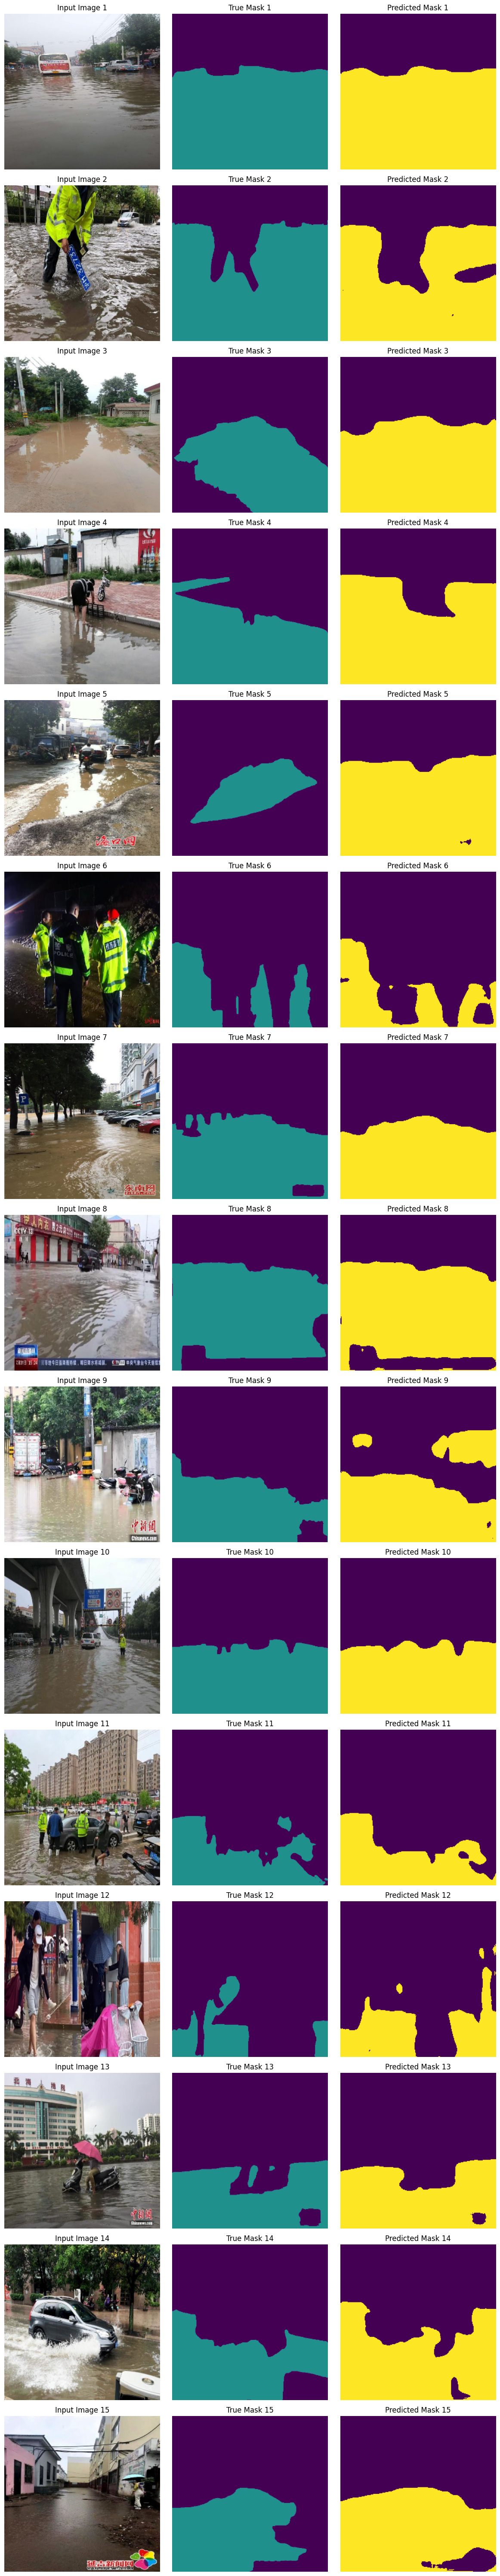

In [31]:
# 预测整个测试集
predictions = model.predict(x_test)

# 随机选择15个样本的索引
sample_indices = np.random.choice(len(x_test), 15, replace=False)  # 随机选择15个索引
sample_images = x_test[sample_indices]
sample_masks = y_test[sample_indices]
sample_predictions = predictions[sample_indices]

# 将预测结果转化为二值掩码，使用阈值0.3
sample_predictions_binary = (sample_predictions > 0.2).astype(np.float32)

# 绘制多个样本的函数
def plot_samples(images, true_masks, pred_masks):
    num_samples = len(images)
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # 输入图像
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f'Input Image {i+1}')
        plt.imshow(images[i])
        plt.axis('off')

        # 真实掩码
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f'True Mask {i+1}')
        colored_mask = get_colored_mask(true_masks[i])  # 使用彩色掩码显示
        plt.imshow(colored_mask)
        plt.axis('off')

        # 预测掩码
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f'Predicted Mask {i+1}')
        colored_mask = get_colored_mask(pred_masks[i])  # 使用彩色掩码显示
        plt.imshow(colored_mask)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 绘制15个样本的输入图像、真实掩码和预测掩码
plot_samples(sample_images, sample_masks, sample_predictions_binary)

## Display the Results